## Neocognitron group 4
### Members: Zernab Saeed, Alejandro Lopez, Daniel Sindel, Pratap Karki, Michael Kwarteng

Caption generation is a challenging artificial intelligence problem of generation human-readable
textual description given a photographic image. It requires both understanding the domain of
computer vision and a language model from the field of natural language processing. The objective
of this demo is help be able to use jupyter notebook to build a deep learning Neural Network that
generates a caption after analyzing an image. We will use the Encoder-Decoder Architecture to
build the network. To feed the model, we prepare data from the ImageNet data collection. The
Xception, which is a pre-trained Convolutional Neural Network that extracts picture features from
our dataset,serves as the encoder’s input layer. We used a model designed by akarsh-saxena on github
at https://github.com/akarsh-saxena/Image-Caption-Generator/blob/master/Image%20Caption%20Generator.ipynb,
then we applied this model to our image dataset and coresponding captions. His model concatenates the 
Xception model with a Long-Short Term Memory layer that acts as a decoder which will decode the vector
representation into the corresponding output sequence using another recurrent hidden layer.

In [1]:
import os
import re
import gc
import numpy as np 
import collections
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from tqdm.notebook import tqdm

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add

In [2]:
def clean_description(desc, stopwords):
    clean = desc.lower()
    clean = re.sub('[^a-z]',' ',clean)
    tokens = clean.split(' ')
    clean = ' '.join([w for w in tokens if w not in stopwords and len(w)>1])
  
    return clean

In [3]:
def get_vocabulary(dictionary):
    vocab = set()

    for desc_list in dictionary.values():
        for desc in desc_list:
            words = desc.split(' ')
            for word in words:
                vocab.add(word)

    return vocab

In [4]:
def create_list(dictionary):
    final_list = []
    
    for desc_list in dictionary.values():
        for desc in desc_list:
            final_list.append(desc)

    return final_list

In [5]:
def fit_tokenizer(dictionary):
    desc_list = create_list(dictionary)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [6]:
def convert_to_input(tokens, pos, im_name, max_len, vocab_len, tokenizer, img_predictions):
    inp = tokens[:pos]
    out = tokens[pos]
    inp = pad_sequences(sequences=[inp], maxlen=max_len)[0]
    out = to_categorical(y=[out], num_classes=vocab_len, dtype='bool')[0]
  
    return img_predictions.get(im_name)[0], inp, out

In [44]:
def convert_all_to_input(dictionary, max_len, vocab_len, tokenizer, img_predictions):
  
    X_1 = list()
    X_2 = list()
    y = list()

    for im_name, descriptions in tqdm(dictionary.items()):
        if im_name in img_predictions.keys():
            for desc in descriptions:
                tokens = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(tokens)):
                    _X_1, _X_2, _y = convert_to_input(tokens, i,
                                    im_name, max_len, vocab_len, tokenizer, img_predictions)
                    #print(_X_1.shape, _X_2.shape, _y.shape,'\n',_X_1, _X_2, _y,"\n")
                    X_1.append(_X_1)
                    X_2.append(_X_2)
                    y.append(_y)
    return np.array(X_1), np.array(X_2), np.array(y)

In [8]:
def shuffle_arrays(arrays, set_seed=-1):
   # """Shuffles arrays in-place, in the same order, along axis=0

  #  Parameters:
  #  -----------
   # arrays : List of NumPy arrays.
   # set_seed : Seed value if int >= 0, else seed is random.
    #"""
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [9]:
def create_model(cnn_len, max_len, vocab_len):
    cnn_in = Input(shape=(cnn_len,))
    cnn_x = Dropout(0.5)(cnn_in)
    cnn_out = Dense(units=256, activation='relu')(cnn_x)

    lstm_in = Input(shape=(max_len,))
    lstm_x = Embedding(vocab_len, 256, mask_zero=True)(lstm_in)
    lstm_x = Dropout(0.5)(lstm_x)
    lstm_out = LSTM(256)(lstm_x)

    combined = add([cnn_out, lstm_out])
    combined_x = Dense(units=256, activation='relu')(combined)
    output = Dense(units=vocab_len, activation='softmax')(combined_x)

    model = Model(inputs=[cnn_in, lstm_in], outputs=output)

    return model

In [10]:
def word_for_id(integer, tokenizer):

    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    
    return None

In [43]:
def generate_desc(model, tokenizer, photo, max_len):

    start_text = 'startseq'

    for i in range(max_len):

        tokens = tokenizer.texts_to_sequences([start_text])[0]

        tokens = pad_sequences([tokens], maxlen=max_len)

        print(photo.size, tokens.size,"\n")
        
        pred = model.predict([photo, tokens], verbose=0)

        pred = np.argmax(pred)

        word = word_for_id(pred, tokenizer)

        if word is None:
            break

        start_text += ' ' + word

        if word == 'endseq':
            break

    return start_text

In [12]:
with open('/home/jovyan/CSCI 4850 Neural Nets/Project-group4/s21-team4-project/ImageNetDataset/xception_example.txt', 'r') as f:
    few_desc = f.read().split('\n')

In [13]:
few_desc[:5]

['image_0.JPEG\tparakeet on laptop',
 'image_1.JPEG\tdog with sheep',
 'image_2.JPEG\tcow udder',
 'image_3.JPEG\ttwo puppies playing',
 'image_4.JPEG\tEgyptian cat looking at camera']

In [14]:
stop_words = ['on', 'with', 'looking', 'the', 'was']

In [15]:
all_dict = dict()

for desc in few_desc:
    if len(desc) < 1:
        continue
    file_name, file_desc = desc.split('\t')[0].split('.')[0], desc.split('\t')[1]
  
    if file_name not in all_dict.keys():
        all_dict[file_name] = []

    cleaned_desc = clean_description(file_desc, stop_words)
    cleaned_desc = 'startseq ' + cleaned_desc + ' endseq'

    all_dict[file_name].append(cleaned_desc)

In [16]:
vocab = get_vocabulary(all_dict)

In [17]:
print('Total images:', len(all_dict))
print('Total vocabulary without stopwords:', len(vocab))

Total images: 100
Total vocabulary without stopwords: 170


In [18]:
whole_list = [item.strip('startseq').strip('endseq').strip(' ') for sublist in list(all_dict.values()) for item in sublist]

In [19]:
whole_list_len = [len(sent) for sent in whole_list]

In [20]:
avg_len = int(np.mean([len(sentence.split()) for sentence in whole_list]))
avg_len

3

In [21]:
words = [w for a in whole_list for w in a.split(' ')]

In [22]:
counts = collections.Counter(words)
most_common = counts.most_common()
most_common[:15]

[('dog', 33),
 ('cat', 33),
 ('in', 18),
 ('and', 13),
 ('black', 12),
 ('white', 11),
 ('camera', 8),
 ('to', 8),
 ('two', 7),
 ('brown', 7),
 ('trying', 7),
 ('at', 6),
 ('sheep', 5),
 ('cow', 5),
 ('cute', 5)]

In [23]:
keys = [tupl[0] for tupl in most_common][:15]
values = [tupl[1] for tupl in most_common][:15]

In [24]:
lengths = set()
for cap_list in all_dict.values():
    lengths.add(len(cap_list))

print('Number of captions for each image: ', lengths)

Number of captions for each image:  {1}


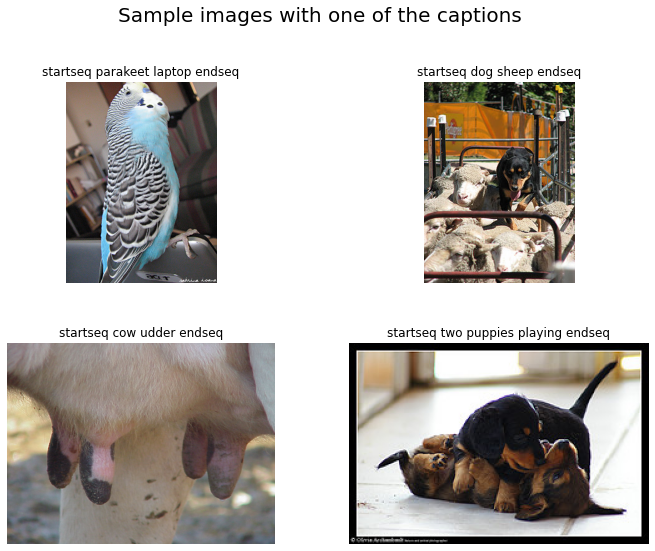

In [25]:
fig = plt.figure()
fig.suptitle('Sample images with one of the captions', fontsize=20)

zoom = 2
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.imshow(plt.imread('/home/jovyan/CSCI 4850 Neural Nets/Project-group4/s21-team4-project/ImageNetDataset/images/' +list(all_dict.keys())[i-1]+'.JPEG'))
    title = ax.set_title('\n'.join(wrap(all_dict.get(list(all_dict.keys())[i-1])[0], 60)))
    fig.tight_layout(h_pad=2)
    title.set_y(1.05)
    plt.axis('off')
    fig.subplots_adjust(top=0.85, hspace=0.3)

plt.show()

In [26]:
model = Xception(include_top=False, pooling='avg')

In [27]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [28]:
predictions = dict()

for dirpath, dirname, files in os.walk('ImageNetDataset/images'):
    for filename in tqdm(files):
        img_path = os.path.join(dirpath, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            img = img.resize((299,299))
            img = np.expand_dims(img, axis=0)
            img = img/127.5
            img = img - 1.0
             
            predictions[filename.split('.')[0]] = model.predict(img)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
print('Number of extracted features:', len(predictions.get(list(predictions.keys())[0])[0]))

Number of extracted features: 2048


In [30]:
tokenize_words = fit_tokenizer(all_dict)

In [31]:
vocab_length = len(tokenize_words.index_word) + 1
vocab_length

170

In [32]:
max_length = len(max(create_list(all_dict)))
max_length

39

In [33]:
network_length = predictions[list(predictions.keys())[0]].shape[1]
network_length

2048

In [34]:
X_1, X_2, y = convert_all_to_input(all_dict, max_length, vocab_length, tokenize_words, predictions)

  0%|          | 0/100 [00:00<?, ?it/s]

(2048,) (39,) (170,) 
 [0.16804159 0.0028348  0.28810593 ... 0.         0.096549   0.23252378] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1] [False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False Fa

In [35]:
shuffle_arrays([X_1, X_2, y])

In [36]:
model = create_model(network_length, max_length, vocab_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics=[tf.keras.metrics.categorical_accuracy])

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 39)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 39, 256)      43520       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

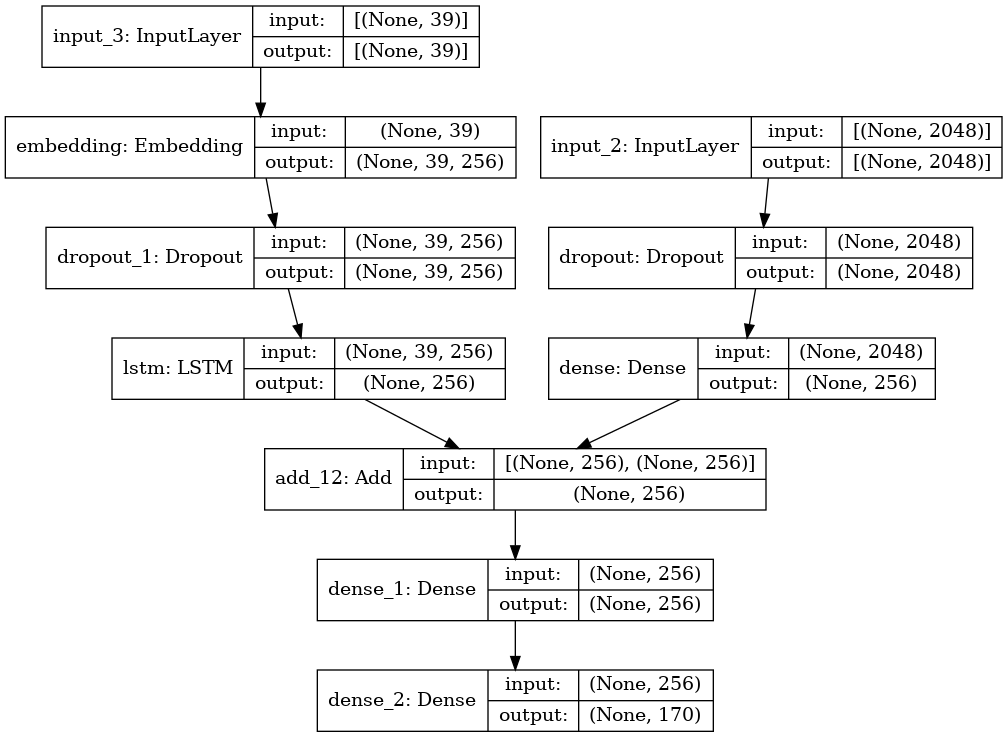

In [38]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
history = model.fit([X_1, X_2], y, epochs = 50, batch_size = 256)

Epoch 1/50
2/2 [==============================] - 6s 437ms/step - loss: 5.1131 - categorical_accuracy: 0.0436
Epoch 2/50
2/2 [==============================] - 1s 467ms/step - loss: 4.6426 - categorical_accuracy: 0.2105
Epoch 3/50
2/2 [==============================] - 1s 423ms/step - loss: 4.3527 - categorical_accuracy: 0.2066
Epoch 4/50
2/2 [==============================] - 1s 428ms/step - loss: 4.2860 - categorical_accuracy: 0.1949
Epoch 5/50
2/2 [==============================] - 1s 432ms/step - loss: 4.1128 - categorical_accuracy: 0.1947
Epoch 6/50
2/2 [==============================] - 1s 422ms/step - loss: 4.0287 - categorical_accuracy: 0.1917
Epoch 7/50
2/2 [==============================] - 1s 445ms/step - loss: 3.9546 - categorical_accuracy: 0.1973
Epoch 8/50
2/2 [==============================] - 1s 414ms/step - loss: 3.8506 - categorical_accuracy: 0.2174
Epoch 9/50
2/2 [==============================] - 1s 413ms/step - loss: 3.7505 - categorical_accuracy: 0.2185
Epoch 10/5

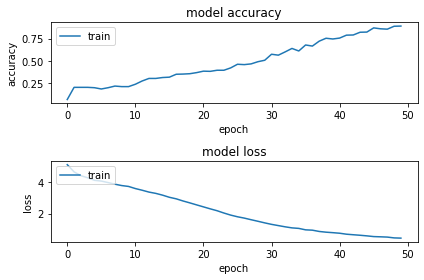

In [40]:
plt.figure(1) 
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show() 

In [41]:
img_path = 'ImageNetDataset/images/image_1.JPEG'
img = Image.open(img_path)
img2 = img.copy()
img = img.resize((299,299))
img = np.expand_dims(img, axis=0)
img = img/127.5
img = img - 1.0
print(img.shape)

(1, 299, 299, 3)


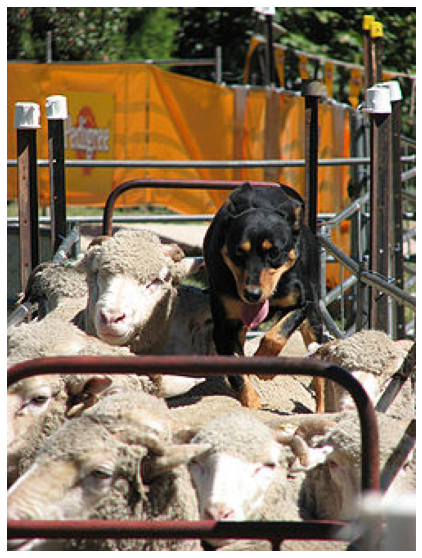

83130 170 



ValueError: Data cardinality is ambiguous:
  x sizes: 489, 1
Make sure all arrays contain the same number of samples.

In [45]:
predict = model.predict([X_1,X_2])

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.axis('off')
plt.show()

caption = generate_desc(model, tokenize_words, predict, vocab_length)
caption = caption.strip('startseq').strip('endseq')
print(caption)